In [1]:
import pickle 
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#garantizamos mismos resultados entre ejecuciones
import os
os.environ['PYTHONHASHSEED']='0'
rs = 1234  # Semilla aleatoria
np.random.seed(rs)
tf.random.set_seed(rs)

In [3]:
#permite guardar el modelo serializandolo
def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()

In [4]:
# pinta las metricas de cada epoca....

def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [5]:
# creacion del modelo de red neuronal
# capa de entrada de usuarios:
#    codificados como one-hot,por lo tanto tiene de dimension el numero 
#    de usuarios distintos del conjunto
#
# K=32
# LR=1e-3
# num_users=943
# num_pelis=1682
# dim_users=dim_pelis=1
# peso_score=0,5  --> lo iremos variando para dar mas peso a entrenar las valoraciones o los géneros

def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    
    usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="usr_dot")(usuarios)  # (?, num_genres)
   
    #usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='relu', name="usr_dot")(usuarios)  # (?, num_genres)
    #usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='tanh', name="usr_dot")(usuarios)

    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)
    #genre_pred = tf.keras.layers.Dense(num_genres, activation='relu', name="genres")(pelis)  # (?, num_genres)
    #genre_pred = tf.keras.layers.Dense(num_genres, activation='tanh', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usr_emb_genr, genre_pred])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred, genre_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss={
            "scores": tf.keras.losses.MeanSquaredError(),
            # "scores": keras.losses.MeanAbsoluteError(),
            "genres": tf.keras.losses.BinaryCrossentropy(),  # (from_logits=True),
        },
        loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error', tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usr_emb_genr],
    )

    
    output_array2 = model.predict([valoraciones.user_id, valoraciones.item_id])
    

    return model, model_usr


In [6]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        # early_stop = EarlyStopping(monitor='val_scores_loss', patience=20)

        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T_{epoch:06d}.h5', save_best_only=True)
        history = model.fit(x=[X_train.user_id, X_train.item_id], y=[y_train.rating, y_train[col_items]],
                            validation_data=([X_dev.user_id, X_dev.item_id], [y_dev.rating, y_dev[col_items]]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train['rating'].mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T+D_{epoch:06d}.h5')
        history = model.fit(x=[X_train_dev.user_id, X_train_dev.item_id],
                            y=[y_train_dev.rating, y_train_dev[col_items]],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])
        media_en_train = y_train_dev['rating'].mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test.item_id], [y_test.rating, y_test[col_items]])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test                   score_loss: %.4f' % losses[1])
    print('\t*-* Test                  gender_loss: %.4f' % losses[2])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[3])
    print('\t*-* Test binary accuracy sobre genres: %.4f' % losses[6])

    print("excel: %.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (losses[0], losses[1], losses[2], losses[3], losses[6]))

    prediction = model.predict([X_test.user_id, X_test.item_id])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test['rating'] - prediction[0].flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test['rating'] - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    # plot_metric(history, 'loss', valida=VALIDATION)
    # plot_metric(history, 'scores_loss', valida=VALIDATION)
    plot_metric(history, 'genres_loss', valida=VALIDATION)
    plot_metric(history, 'scores_mean_absolute_error', valida=VALIDATION)
    # plot_metric(history, 'genres_binary_accuracy', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g



In [7]:
def radar_chart(line_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- radar_chart: genera el radar_chart ")
    print("-------------------------------------------------------------------------------------------------")
    num_user = line_out.user_id  #.iloc[line]
    num_peli = line_out.item_id  #.iloc[line]
    titulo_peli = items[items.item_id == num_peli].title.values[0]

    # number of variable
    categories = names  # list(df)[2:]  # para quitar user_id y rating de las etiquetas
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(6, 7))
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable
    plt.xticks(angles[:-1], categories)

    # ------- PART 2: Add plots
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Usuario
    # values_user = line_out[unames].iloc[line].values.tolist()
    values_user = line_out[unames].values.tolist()
    values_user += values_user[:1]
    ax.plot(angles, values_user, linewidth=1, linestyle='solid', label="Usuario - predicho")
    ax.fill(angles, values_user, 'b', alpha=0.1)

    # Predicción géneros película
    values_peli = line_out[pnames].values.tolist()
    values_peli += values_peli[:1]
    ax.plot(angles, values_peli, linewidth=1, linestyle='solid', label="Predicho - "+titulo_peli)
    ax.fill(angles, values_peli, 'r', alpha=0.1)

    # géneros película verdaderos
    true_values_peli = line_out[prnames].values.tolist()
    true_values_peli += true_values_peli[:1]
    ax.plot(angles, true_values_peli, linewidth=1, linestyle='solid', label="Real - "+titulo_peli)
    ax.fill(angles, true_values_peli, 'g', alpha=0.1)

    # Draw ylabels
    ax.set_rlabel_position(0)
    v = max(max(values_user), max(values_peli)) / 4
    plt.yticks([v, v*2, v*3], [str(round(v, 4)), str(round(v*2, 4)), str(round(v*3, 4))], color="grey", size=7)
    plt.ylim(0, max(max(values_user), max(values_peli)))

    # Add legend
    plt.legend(loc='lower left', bbox_to_anchor=(-0.15, -0.23))

    nota_media_users = df_train_dev['rating'].groupby(df_train_dev['user_id']).mean().reset_index()
    nota_media_pelis = df_train_dev['rating'].groupby(df_train_dev['item_id']).mean().reset_index()
    nota_media_usr = nota_media_users[nota_media_users.user_id == num_user].rating.values[0]
    nota_media_peli = nota_media_pelis[nota_media_pelis.item_id == num_peli].rating.values[0]
    titulo = 'Usuario ' + str(int(num_user)) + ' (nota media: ' + str(np.round(nota_media_usr, 2)) + ')\n' + \
             titulo_peli + ' (nota media: ' + str(np.round(nota_media_peli, 2)) + ')\n' + \
             ' Nota predicha: ' + str(np.round(line_out.rating, 2))

    plt.title(titulo)
    # Show the graph
    plt.show()


In [8]:

def topNrankings(N, line_out, names, unames, pnames, prnames, verbose=False):
    # line_out = df_out.iloc[7]
    usuario = line_out[unames].copy()
    usuario.rename(dict(zip(unames, names)), axis='columns', inplace=True)
    peli = line_out[pnames].copy()
    peli.rename(dict(zip(pnames, names)), axis='columns', inplace=True)
    peli_real = line_out[prnames].copy()
    peli_real.rename(dict(zip(prnames, names)), axis='columns', inplace=True)
    top5user = usuario.sort_values(ascending=False)[0:N]
    top5peli = peli.sort_values(ascending=False)[0:N]
    top5real = peli_real.sort_values(ascending=False)[0:N]
    inters_genres = top5user.index & top5peli.index
    if verbose:
        print("-------------------------------------------------------------------------------------------------")
        print("----- topNrankings: muestra los TopN y calcula la intersección ")
        print("-------------------------------------------------------------------------------------------------")
        print("Top", N, "de géneros del usuario según el modelo:")
        print(top5user)
        print("Top", N, "de géneros de la película según el modelo:")
        print(top5peli)
        print("Top", N, "de géneros de la película según MovieLens:")
        print(top5real)
        print("Intersección usuario-película en top", N, "según el modelo:")
        print(inters_genres)
        print("Número de elementos en la intersección:", len(inters_genres))
        print("Puntuación predicha (real) para la película: %.2f (%.0f)" % (line_out.rating, line_out.rat_real))
    return len(inters_genres)


In [9]:

def genres_bar_chart(genre_names, gen_reales, gen_predichos):
    x = np.arange(len(genre_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, gen_reales, width, label='Géneros reales')
    rects2 = ax.bar(x + width / 2, gen_predichos, width, label='Géneros predichos')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('media')
    ax.set_title('Media de géneros de las películas')
    ax.set_xticks(x)
    ax.set_xticklabels(genre_names, rotation='vertical')
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()


In [10]:

def compara_generos(df_out, pnames, prnames):
    dfo = df_out[pnames + prnames].groupby(df_out['item_id']).mean().reset_index()
    # genres_bar_chart(names, dfo[prnames].sum(), dfo[pnames].sum())
    genres_bar_chart(names, dfo[prnames].mean(), dfo[pnames].mean())
    print('Correlación: ', np.corrcoef(dfo[prnames].mean(), dfo[pnames].mean())[0,1])
    dfo[dfo[pnames] < 0.5] = 0
    dfo[dfo[pnames] >= 0.5] = 1
    genres_por_peli_pred = np.sum(dfo[pnames], axis=1)
    genres_por_peli_real = np.sum(dfo[prnames], axis=1)
    print("-------------------------------------------------------------------------------------------------")
    print("----- compara_generos: genera el barchart y muestra media de géneros por película")
    print("-------------------------------------------------------------------------------------------------")
    print("Media de géneros por película en test (real):", genres_por_peli_real.mean())
    print("Media de géneros por película en test (pred):", genres_por_peli_pred.mean())
    dfo['dif_genres'] = genres_por_peli_pred - genres_por_peli_real
    dfo.to_csv('dif_genres.csv', sep=';', decimal=',')



In [11]:
def explica(linea, df_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- explica: muestra qué géneros influyen más en la valoración")
    print("-------------------------------------------------------------------------------------------------")
    importancia_genres = np.multiply(df_out[unames], df_out[pnames])
    print("Valor predicho: %.2f" % (importancia_genres.iloc[linea].sum()))
    genres_ordenados = importancia_genres.iloc[linea].sort_values(ascending=False)
    print("Géneros que más aportan:")
    print(genres_ordenados[0:5])
    suma = genres_ordenados[0:5].sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma*100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))
    # aportación de los géneros con predicción >=05
    mask = df_out.iloc[linea][pnames] >= 0.5
    gen_ge_05 = importancia_genres.iloc[linea, mask.values.tolist()]
    print("Aportación de los géneros >= 0.5:")
    print(gen_ge_05.sort_values(ascending=False))
    suma = gen_ge_05.sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma * 100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))


In [12]:
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

PATH = '/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-100k/'

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# VALORACIONES
# ---------------------------------------------------------------------------------------------------------------------
valoraciones = pd.read_csv(PATH+'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
print(valoraciones)

# quito el timestamp porque no me interesa
valoraciones.drop(['timestamp'], axis='columns', inplace=True)

# de momento dejo el rating como un problema de regresión
print(valoraciones)

num_ejem = valoraciones.shape[0]
num_users = valoraciones.user_id.max()+1  # 943, del 1 al 943. El +1 es porque empieza en 0
num_pelis = valoraciones.item_id.max()+1  # 1682, del 1 al 1682

       user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]
       user_id  item_id  rating
0          196      242       3
1          186      302       3
2           22      377       1
3          244       51       2
4          166      346       1
...        ...      ...     ...
99995      880      476       3
99996      716      204       5
99997      276     1090       1
99998       13      225       2
99999       12      203       3

[100000 rows x 3 columns]


In [13]:

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ITEMS (PELÍCULAS)
# ---------------------------------------------------------------------------------------------------------------------
items = pd.read_csv(PATH+'u.item', sep='|', names=['item_id', 'title', 'RD', 'VRD', 'IMDB', 'unknown', 'Action',
                                                   'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                                   'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical',
                                                   'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western'])
print(items)
# de las películas me quedo sólo con los géneros de las mismas. El resto de campos los elimino
# dejo el item_id para comprobaciones
# titles = items.loc[:, ['item_id', 'title']]

items.drop(['RD', 'VRD', 'IMDB', 'unknown'], axis='columns', inplace=True)
print(items)

num_genres = items.shape[1]-2  # el -2 es para no contar el item_id ni el título. Son 18 géneros



      item_id                                      title           RD  VRD  \
0           1                           Toy Story (1995)  01-Jan-1995  NaN   
1           2                           GoldenEye (1995)  01-Jan-1995  NaN   
2           3                          Four Rooms (1995)  01-Jan-1995  NaN   
3           4                          Get Shorty (1995)  01-Jan-1995  NaN   
4           5                             Copycat (1995)  01-Jan-1995  NaN   
...       ...                                        ...          ...  ...   
1677     1678                          Mat' i syn (1997)  06-Feb-1998  NaN   
1678     1679                           B. Monkey (1998)  06-Feb-1998  NaN   
1679     1680                       Sliding Doors (1998)  01-Jan-1998  NaN   
1680     1681                        You So Crazy (1994)  01-Jan-1994  NaN   
1681     1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996  NaN   

                                                   IMDB  unknow

In [14]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# PREPARANDO EL CONJUNTO DE DATOS
# ---------------------------------------------------------------------------------------------------------------------
cjto = valoraciones

# genera un indice con los generos de las peliculas
col_items = items.columns.drop(['item_id', 'title'])
#print(col_items)

# añado las columnas para el item ceros
cjto[col_items] = np.zeros((cjto.shape[0], col_items.shape[0]), dtype='int32')


# relleno los items con sus valores
for i in range(items.shape[0]):
    num_item = items.iloc[i].item_id
    #if i % 20 == 0: 
    #  print("item:", num_item)
    cjto.loc[cjto.item_id == num_item, col_items] = items.iloc[i, 2:].to_list()  # se salta item_id y title

# se almacenas en un fichero los ejemplos
# cjto.to_pickle('SPARSES/ML100K_CASOS_USO.pkl')

# X / y
X = cjto[['user_id', 'item_id']].copy()

y = cjto[col_items.insert(0, 'rating')].copy()
print(y)
TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)

       rating  Action  Adventure  Animation  Children  Comedy  Crime  \
0           3       0          0          0         0       1      0   
1           3       0          0          0         0       0      1   
2           1       0          0          0         1       1      0   
3           2       0          0          0         0       0      0   
4           1       0          0          0         0       0      1   
...       ...     ...        ...        ...       ...     ...    ...   
99995       3       0          0          0         0       1      0   
99996       5       0          0          0         0       1      0   
99997       1       0          0          0         0       0      0   
99998       2       0          0          0         1       1      0   
99999       3       0          0          0         0       0      0   

       Documentary  Drama  Fantasy  FilmNoir  Horror  Musical  Mystery  \
0                0      0        0         0       0        0

In [15]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32
learning_rate = 1e-3
dim_input_users = 1  # el entero a partir del cual se calcula el embedding ##????
dim_input_pelis = 1  # el entero a partir del cual se calcula el embedding ##????
tam_batch = 512 
max_epochs = 1000 
peso_score = 0.5  # valor entre 0 y 1.0

Epoch 1/1000
159/159 [==============================] - 1s 3ms/step - loss: 1.1678 - scores_loss: 1.6726 - genres_loss: 0.6630 - scores_mean_absolute_error: 1.0062 - scores_binary_accuracy: 0.0607 - genres_mean_absolute_error: 0.4840 - genres_binary_accuracy: 0.7716 - val_loss: 0.7961 - val_scores_loss: 0.9844 - val_genres_loss: 0.6078 - val_scores_mean_absolute_error: 0.7969 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.4526 - val_genres_binary_accuracy: 0.8350
Epoch 2/1000
159/159 [==============================] - 0s 2ms/step - loss: 0.7703 - scores_loss: 0.9370 - genres_loss: 0.6036 - scores_mean_absolute_error: 0.7729 - scores_binary_accuracy: 0.0615 - genres_mean_absolute_error: 0.4498 - genres_binary_accuracy: 0.8251 - val_loss: 0.7509 - val_scores_loss: 0.9139 - val_genres_loss: 0.5879 - val_scores_mean_absolute_error: 0.7634 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.4400 - val_genres_binary_accuracy: 0.8357
Epoch 3/1000

Epoch 18/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.5684 - scores_loss: 0.8499 - genres_loss: 0.2868 - scores_mean_absolute_error: 0.7296 - scores_binary_accuracy: 0.0623 - genres_mean_absolute_error: 0.2322 - genres_binary_accuracy: 0.9594 - val_loss: 0.5938 - val_scores_loss: 0.9102 - val_genres_loss: 0.2774 - val_scores_mean_absolute_error: 0.7550 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.2250 - val_genres_binary_accuracy: 0.9617
Epoch 19/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.5628 - scores_loss: 0.8521 - genres_loss: 0.2735 - scores_mean_absolute_error: 0.7306 - scores_binary_accuracy: 0.0602 - genres_mean_absolute_error: 0.2222 - genres_binary_accuracy: 0.9625 - val_loss: 0.5877 - val_scores_loss: 0.9114 - val_genres_loss: 0.2640 - val_scores_mean_absolute_error: 0.7556 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.2148 - val_genres_binary_accuracy: 0.9642
Epoch 20/1

Epoch 35/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4822 - scores_loss: 0.7859 - genres_loss: 0.1785 - scores_mean_absolute_error: 0.7003 - scores_binary_accuracy: 0.0613 - genres_mean_absolute_error: 0.1508 - genres_binary_accuracy: 0.9823 - val_loss: 0.5292 - val_scores_loss: 0.8814 - val_genres_loss: 0.1770 - val_scores_mean_absolute_error: 0.7434 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1495 - val_genres_binary_accuracy: 0.9821
Epoch 36/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4813 - scores_loss: 0.7860 - genres_loss: 0.1766 - scores_mean_absolute_error: 0.7018 - scores_binary_accuracy: 0.0611 - genres_mean_absolute_error: 0.1492 - genres_binary_accuracy: 0.9817 - val_loss: 0.5265 - val_scores_loss: 0.8774 - val_genres_loss: 0.1756 - val_scores_mean_absolute_error: 0.7408 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1483 - val_genres_binary_accuracy: 0.9814
Epoch 37/1

Epoch 52/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4480 - scores_loss: 0.7334 - genres_loss: 0.1626 - scores_mean_absolute_error: 0.6764 - scores_binary_accuracy: 0.0615 - genres_mean_absolute_error: 0.1369 - genres_binary_accuracy: 0.9786 - val_loss: 0.5154 - val_scores_loss: 0.8679 - val_genres_loss: 0.1629 - val_scores_mean_absolute_error: 0.7370 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1370 - val_genres_binary_accuracy: 0.9781
Epoch 53/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4425 - scores_loss: 0.7229 - genres_loss: 0.1621 - scores_mean_absolute_error: 0.6709 - scores_binary_accuracy: 0.0604 - genres_mean_absolute_error: 0.1364 - genres_binary_accuracy: 0.9780 - val_loss: 0.5153 - val_scores_loss: 0.8690 - val_genres_loss: 0.1616 - val_scores_mean_absolute_error: 0.7384 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1359 - val_genres_binary_accuracy: 0.9784
Epoch 54/1

Epoch 69/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4293 - scores_loss: 0.6993 - genres_loss: 0.1594 - scores_mean_absolute_error: 0.6600 - scores_binary_accuracy: 0.0610 - genres_mean_absolute_error: 0.1330 - genres_binary_accuracy: 0.9733 - val_loss: 0.5124 - val_scores_loss: 0.8670 - val_genres_loss: 0.1579 - val_scores_mean_absolute_error: 0.7383 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1318 - val_genres_binary_accuracy: 0.9732
Epoch 70/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4310 - scores_loss: 0.7035 - genres_loss: 0.1585 - scores_mean_absolute_error: 0.6619 - scores_binary_accuracy: 0.0623 - genres_mean_absolute_error: 0.1322 - genres_binary_accuracy: 0.9730 - val_loss: 0.5120 - val_scores_loss: 0.8639 - val_genres_loss: 0.1601 - val_scores_mean_absolute_error: 0.7358 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1332 - val_genres_binary_accuracy: 0.9722
Epoch 71/1

Epoch 86/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4170 - scores_loss: 0.6723 - genres_loss: 0.1618 - scores_mean_absolute_error: 0.6467 - scores_binary_accuracy: 0.0609 - genres_mean_absolute_error: 0.1333 - genres_binary_accuracy: 0.9681 - val_loss: 0.5136 - val_scores_loss: 0.8665 - val_genres_loss: 0.1608 - val_scores_mean_absolute_error: 0.7377 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1325 - val_genres_binary_accuracy: 0.9682
Epoch 87/1000
159/159 [==============================] - 0s 1ms/step - loss: 0.4151 - scores_loss: 0.6692 - genres_loss: 0.1610 - scores_mean_absolute_error: 0.6458 - scores_binary_accuracy: 0.0615 - genres_mean_absolute_error: 0.1326 - genres_binary_accuracy: 0.9680 - val_loss: 0.5142 - val_scores_loss: 0.8676 - val_genres_loss: 0.1608 - val_scores_mean_absolute_error: 0.7395 - val_scores_binary_accuracy: 0.0622 - val_genres_mean_absolute_error: 0.1324 - val_genres_binary_accuracy: 0.9682
Epoch 88/1

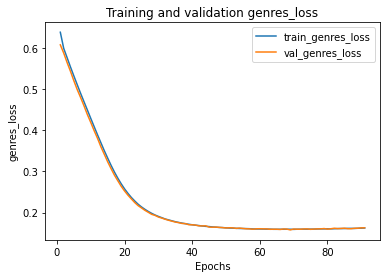

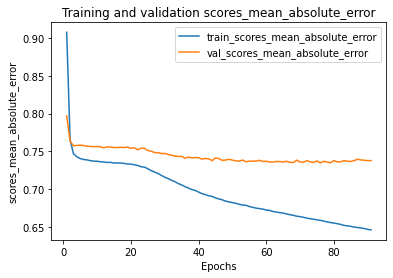

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_usr (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_pelis (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_usr (Embedding)       (None, 1, 32)        30208       input_usr[0][0]                  
__________________________________________________________________________________________________
embedding_pelis (Embedding)     (None, 1, 32)        53856       input_pelis[0][0]                
______________________________________________________________________________________________

In [16]:
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users, num_pelis,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

model.summary()

Epoch 1/90
176/176 [==============================] - 1s 2ms/step - loss: 1.1620 - scores_loss: 1.6626 - genres_loss: 0.6614 - scores_mean_absolute_error: 1.0026 - scores_binary_accuracy: 0.0621 - genres_mean_absolute_error: 0.4831 - genres_binary_accuracy: 0.7695
Epoch 2/90
176/176 [==============================] - 0s 2ms/step - loss: 0.7608 - scores_loss: 0.9188 - genres_loss: 0.6028 - scores_mean_absolute_error: 0.7654 - scores_binary_accuracy: 0.0616 - genres_mean_absolute_error: 0.4492 - genres_binary_accuracy: 0.8270
Epoch 3/90
176/176 [==============================] - 0s 1ms/step - loss: 0.7257 - scores_loss: 0.8735 - genres_loss: 0.5779 - scores_mean_absolute_error: 0.7440 - scores_binary_accuracy: 0.0619 - genres_mean_absolute_error: 0.4339 - genres_binary_accuracy: 0.8523
Epoch 4/90
176/176 [==============================] - 0s 1ms/step - loss: 0.7103 - scores_loss: 0.8670 - genres_loss: 0.5536 - scores_mean_absolute_error: 0.7415 - scores_binary_accuracy: 0.0623 - genres_m

176/176 [==============================] - 0s 1ms/step - loss: 0.4882 - scores_loss: 0.7952 - genres_loss: 0.1812 - scores_mean_absolute_error: 0.7046 - scores_binary_accuracy: 0.0622 - genres_mean_absolute_error: 0.1531 - genres_binary_accuracy: 0.9803
Epoch 32/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4833 - scores_loss: 0.7873 - genres_loss: 0.1793 - scores_mean_absolute_error: 0.7032 - scores_binary_accuracy: 0.0612 - genres_mean_absolute_error: 0.1515 - genres_binary_accuracy: 0.9810
Epoch 33/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4804 - scores_loss: 0.7837 - genres_loss: 0.1770 - scores_mean_absolute_error: 0.6994 - scores_binary_accuracy: 0.0614 - genres_mean_absolute_error: 0.1498 - genres_binary_accuracy: 0.9817
Epoch 34/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4770 - scores_loss: 0.7797 - genres_loss: 0.1744 - scores_mean_absolute_error: 0.6984 - scores_binary_accuracy: 0.0608 - genres_mean_abso

176/176 [==============================] - 0s 1ms/step - loss: 0.4320 - scores_loss: 0.7053 - genres_loss: 0.1587 - scores_mean_absolute_error: 0.6628 - scores_binary_accuracy: 0.0605 - genres_mean_absolute_error: 0.1331 - genres_binary_accuracy: 0.9772
Epoch 62/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4315 - scores_loss: 0.7043 - genres_loss: 0.1587 - scores_mean_absolute_error: 0.6623 - scores_binary_accuracy: 0.0611 - genres_mean_absolute_error: 0.1331 - genres_binary_accuracy: 0.9766
Epoch 63/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4328 - scores_loss: 0.7075 - genres_loss: 0.1582 - scores_mean_absolute_error: 0.6639 - scores_binary_accuracy: 0.0615 - genres_mean_absolute_error: 0.1324 - genres_binary_accuracy: 0.9762
Epoch 64/90
176/176 [==============================] - 0s 1ms/step - loss: 0.4314 - scores_loss: 0.7040 - genres_loss: 0.1588 - scores_mean_absolute_error: 0.6632 - scores_binary_accuracy: 0.0606 - genres_mean_abso

313/313 [==============================] - 0s 433us/step - loss: 0.5034 - scores_loss: 0.8434 - genres_loss: 0.1633 - scores_mean_absolute_error: 0.7176 - scores_binary_accuracy: 0.0603 - genres_mean_absolute_error: 0.1335 - genres_binary_accuracy: 0.9667
	*-* Test                         loss: 0.5034
	*-* Test                   score_loss: 0.8434
	*-* Test                  gender_loss: 0.1633
	*-* Test             MAE sobre scores: 0.7176
	*-* Test binary accuracy sobre genres: 0.9667
excel: 0.5034	0.8434	0.1633	0.7176	0.9667
Test MAE    modelo: 0.7176
Test MAE Sys-Media: 0.9366


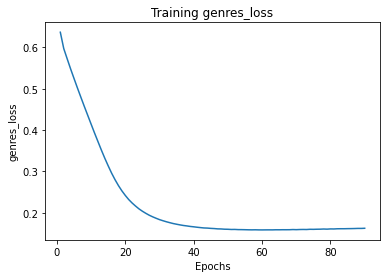

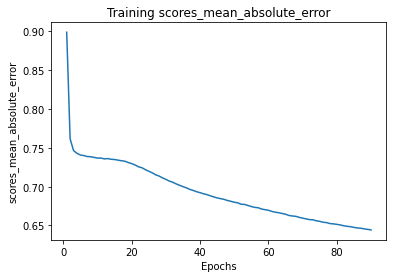

In [17]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

save_to_pickle('ml100k_prediction', prediction)

UNOS en la predicción: 26643
UNOS en el test:       21176


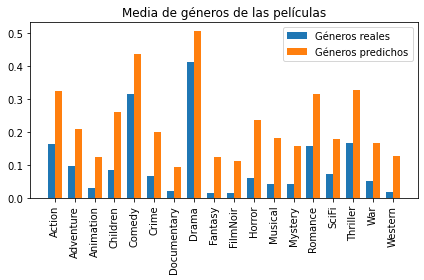

Correlación:  0.9657731144444619
-------------------------------------------------------------------------------------------------
----- compara_generos: genera el barchart y muestra media de géneros por película
-------------------------------------------------------------------------------------------------
Media de géneros por película en test (real): 1.8338632750397457
Media de géneros por película en test (pred): 2.5953895071542132
  ---***--- PREDICCIÓN PARA EL USUARIO 542 ---***---
-------------------------------------------------------------------------------------------------
----- radar_chart: genera el radar_chart 
-------------------------------------------------------------------------------------------------


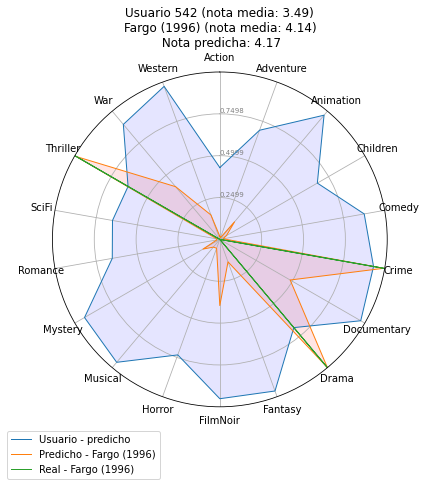

-------------------------------------------------------------------------------------------------
----- topNrankings: muestra los TopN y calcula la intersección 
-------------------------------------------------------------------------------------------------
Top 5 de géneros del usuario según el modelo:
Western        0.972541
Documentary    0.971737
Animation      0.968347
Fantasy        0.963508
Musical        0.958217
Name: 39176, dtype: float64
Top 5 de géneros de la película según el modelo:
Drama          0.999713
Crime          0.993877
Thriller       0.989178
Documentary    0.485062
War            0.411159
Name: 39176, dtype: float64
Top 5 de géneros de la película según MovieLens:
Thriller    1.0
Crime       1.0
Drama       1.0
Action      0.0
Horror      0.0
Name: 39176, dtype: float64
Intersección usuario-película en top 5 según el modelo:
Index(['Documentary'], dtype='object')
Número de elementos en la intersección: 1
Puntuación predicha (real) para la película: 4.17 (4)
-

<ipython-input-8-b37eb4ef8610>:12: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  inters_genres = top5user.index & top5peli.index
<ipython-input-11-aa45e1f70515>:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  importancia_genres = np.multiply(df_out[unames], df_out[pnames])


In [18]:
# se crea un df con los datos de TRAIN+DEV [idusr, iditem, rating, genres]
df_train_dev = X_train_dev.copy()
df_train_dev[y_test.columns] = y_train_dev

# unos que hay en la predicción y en el test
print('UNOS en la predicción:', sum(sum(prediction[1] > 0.5)))
print('UNOS en el test:      ', sum(sum(y_test.values[:, 1:] > 0.5)))

# se crea un df con los datos de TEST [idusr, iditem, rating, genres]
# df_test = X_test.copy()
# df_test[y_test.columns] = y_test

# se crea un df con los datos PREDICHOS [idusr, iditem, rating, genres]
# df_pred = X_test.copy()
# df_pred['rating'] = prediction[0]
# df_pred[y_test.columns[1:]] = prediction[1]

# se crea un dataframe con toda la salida
df_out = X_test.copy()
df_out['rating'] = prediction[0]
df_out['rat_real'] = y_test['rating']
unames = ['u_' + g for g in y_test.columns[1:]]
df_out[unames] = usr_emb_genres  # esto es el mapeado de usuarios en el espacio de géneros
pnames = ['p_' + g for g in y_test.columns[1:]]
df_out[pnames] = prediction[1]  # esto es el mapeado de películas en el espacio de géneros
prnames = ['pr_' + g for g in y_test.columns[1:]]  # pr = películas real
df_out[prnames] = y_test[y_test.columns.drop('rating')]  # esto son los géneros de las películas según MovieLens

# lista con los nombre de los géneros
names = y_test.columns[1:]

# esto es para calcular la intersección de géneros en el top 5 y 10
# esto tarda un poco, así que lo comento y **sólo hay que descomentarlo para los RESULTADOS FINALES**
#df_out['intersecTop5'] = df_out.apply(lambda row: topNrankings(5, row, names, unames, pnames, prnames), axis=1)
#df_out['intersecTop10'] = df_out.apply(lambda row: topNrankings(10, row, names, unames, pnames, prnames), axis=1)
#df_out.to_csv('salida.csv', sep=';', decimal=',')


# hace el barchart
compara_generos(df_out, pnames, prnames)

EXPLICA = True
if EXPLICA:
    # Este código es para ver la recomendación que se hace a un usuario sobre las películas que ha valorado en el test
    # Se cogen las películas que ha valorado y se ordenan por el valor predicho por el modelo
    # Después se analiza y explica la recomendación de la película con mayor valoración (línea 0)
    num_usuario = 542  # 542 712 puede ser un buen ejemplo, 4 starwars, 8 pulpfiction, 9 elpacienteingles

    print("  ---***--- PREDICCIÓN PARA EL USUARIO %d ---***---" %(num_usuario))
    out_by_user = df_out[df_out.user_id == num_usuario].sort_values(by='rating', ascending=False)
    linea = 0  # en la línea 0 de out_by_user está la más valorada y por tanto la recomendada
    # radar_chart(df_out.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    radar_chart(out_by_user.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    topNrankings(5, out_by_user.iloc[linea], names, unames, pnames, prnames, verbose=True)
    explica(linea, out_by_user, df_train_dev, items, names, unames, pnames, prnames)

# esta es la media de géneros en las películas evaluadas por los usuarios
# NO tiene en cuenta las valoraciones
# gustos_usuarios_train = df_train_dev[y_test.columns].groupby(df_train_dev['user_id']).mean().reset_index()


# la predicción que se hace del género de las películas puede ser ligeramente diferente
# de los géneros reales. Eso haría que la proyección de los usuarios en el espacio de los
# géneros sirva para hacer predicciones mejores
# mostar: la proyección del usuario y la película en el espacio de géneros. Ahí se verá que
# géneros son importantes para el usuario a la hora de puntuar la película. Además se puede
# comparar el vector de géneros verdadero de la película con el predicho.
# Hay que ver cómo se hace para que el modelo mapee los usuarios en el espacio de los géneros
# para poder mostrarlos en la explicación

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")
